In [ ]:
pip install squarify

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as  plt
import plotly.express as px
import os
import folium
from folium.plugins import HeatMap
from functools import reduce
import squarify as sq
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hudanazmul","key":"edc6418069a0ef67131479fb3f0ab515"}'}

In [ ]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

ref                                                         title                                               size  lastUpdated          downloadCount  
----------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  
yamqwe/omicron-covid19-variant-daily-cases                  Omicron daily cases by country (COVID-19 variant)  432KB  2022-01-22 23:34:03           6946  
nkitgupta/jigsaw-regression-based-data                      Jigsaw Regression Based Data                         3GB  2022-01-10 06:29:59            423  
prasertk/netflix-subscription-price-in-different-countries  Netflix subscription fee in different countries      3KB  2022-01-15 07:06:09            632  
yasserh/song-popularity-dataset                             Song Popularity Dataset                            805KB  2022-01-07 13:18:43           1002  
vishalmane10/anime-dataset-2022                             Anime Data

In [ ]:
!kaggle datasets download -d olistbr/brazilian-ecommerce

 73% 31.0M/42.6M [00:00<00:00, 87.0MB/s]
100% 42.6M/42.6M [00:00<00:00, 142MB/s] 


In [ ]:
!unzip brazilian-ecommerce.zip

Archive:  brazilian-ecommerce.zip
  inflating: olist_customers_dataset.csv  
  inflating: olist_geolocation_dataset.csv  
  inflating: olist_order_items_dataset.csv  
  inflating: olist_order_payments_dataset.csv  
  inflating: olist_order_reviews_dataset.csv  
  inflating: olist_orders_dataset.csv  
  inflating: olist_products_dataset.csv  
  inflating: olist_sellers_dataset.csv  
  inflating: product_category_name_translation.csv  


In [ ]:
#Reading the Data

customer = pd.read_csv("/content/olist_customers_dataset.csv")
geolocation = pd.read_csv("/content/olist_geolocation_dataset.csv")
order_item = pd.read_csv("/content/olist_order_items_dataset.csv")
order_payments = pd.read_csv("/content/olist_order_payments_dataset.csv")
order_reviews = pd.read_csv("/content/olist_order_reviews_dataset.csv")
orders = pd.read_csv("/content/olist_orders_dataset.csv")
products = pd.read_csv("/content/olist_products_dataset.csv")
sellers = pd.read_csv("/content/olist_sellers_dataset.csv")
product_traslation = pd.read_csv("/content/product_category_name_translation.csv")

In [ ]:
# Lets check the size of each df:
df_names = ['customer','geolocation', 'orders', 'order_item','order_payments',
            'order_reviews','products','sellers','product_traslation']
for df in df_names:
    print("Dataset {} has shape {}".format(df, eval(df).shape))

Dataset customer has shape (99441, 5)
Dataset geolocation has shape (1000163, 5)
Dataset orders has shape (99441, 8)
Dataset order_item has shape (112650, 7)
Dataset order_payments has shape (103886, 5)
Dataset order_reviews has shape (99224, 7)
Dataset products has shape (32951, 9)
Dataset sellers has shape (3095, 4)
Dataset product_traslation has shape (71, 2)


In [ ]:
# Lets check the null values:

for df in df_names:
    print("In {} there are approximately {} null values".format(df, eval(df).isnull().sum().sum()))

In customer there are approximately 0 null values
In geolocation there are approximately 0 null values
In orders there are approximately 4908 null values
In order_item there are approximately 0 null values
In order_payments there are approximately 0 null values
In order_reviews there are approximately 145903 null values
In products there are approximately 2448 null values
In sellers there are approximately 0 null values
In product_traslation there are approximately 0 null values


In [ ]:
orders.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [ ]:
#Working with Missing Data

orders["order_approved_at"] = orders["order_approved_at"].fillna(orders["order_purchase_timestamp"])
orders["order_delivered_carrier_date"] = orders["order_delivered_carrier_date"].fillna(orders["order_approved_at"])
orders["order_delivered_customer_date"] = orders["order_delivered_customer_date"].fillna(orders["order_estimated_delivery_date"])

In [ ]:
orders.isnull().sum()

order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
dtype: int64

In [ ]:
products.isnull().sum()

product_id                      0
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64

In [ ]:
products = products[~(products['product_name_lenght'].isnull())]
products = products[~(products['product_weight_g'].isnull())]

In [ ]:
products.isnull().sum()

product_id                    0
product_category_name         0
product_name_lenght           0
product_description_lenght    0
product_photos_qty            0
product_weight_g              0
product_length_cm             0
product_height_cm             0
product_width_cm              0
dtype: int64

In [ ]:
order_reviews.isnull().sum()

review_id                      0
order_id                       0
review_score                   0
review_comment_title       87656
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64

In [ ]:
# drop the review_comment_title column
order_reviews = order_reviews.drop(['review_comment_title'],axis =1 )


In [ ]:
#Replace missing review messages with string 'NONE'
order_reviews['review_comment_message'] = order_reviews['review_comment_message'].fillna('NONE')

In [ ]:
order_reviews.isnull().sum()

review_id                  0
order_id                   0
review_score               0
review_comment_message     0
review_creation_date       0
review_answer_timestamp    0
dtype: int64

In [ ]:
# Merge all the datasets and then analyse null values and clean 

df = pd.merge(orders,order_payments, on="order_id")
df = pd.merge(df,customer, on="customer_id")
df = pd.merge(df,order_item, on="order_id")
df = pd.merge(df,sellers, on="seller_id")
df = pd.merge(df,order_reviews, on="order_id")
df = pd.merge(df,products, on="product_id")
df = pd.merge(df,product_traslation, on="product_category_name")

df.shape

(115608, 39)

In [ ]:
df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,seller_zip_code_prefix,seller_city,seller_state,review_id,review_score,review_comment_message,review_creation_date,review_answer_timestamp,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1,credit_card,1,18.12,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,9350,maua,SP,a54f0611adc9ed256b57ede6b6eb5114,4,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,3,voucher,1,2.00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,9350,maua,SP,a54f0611adc9ed256b57ede6b6eb5114,4,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,2,voucher,1,18.59,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,9350,maua,SP,a54f0611adc9ed256b57ede6b6eb5114,4,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28 00:00:00,1,credit_card,3,37.77,3a51803cc0d012c3b5dc8b7528cb05f7,3366,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-21 20:05:16,29.99,7.78,9350,maua,SP,b46f1e34512b0f4c74a72398b03ca788,4,Deveriam embalar melhor o produto. A caixa vei...,2017-08-19 00:00:00,2017-08-20 15:16:36,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15 00:00:00,1,credit_card,1,37.77,ef0996a1a279c26e7ecbd737be23d235,2290,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-08 18:37:31,29.99,7.78,9350,maua,SP,dc90f19c2806f1abba9e72ad3c350073,5,"Só achei ela pequena pra seis xícaras ,mais é ...",2017-08-08 00:00:00,2017-08-08 23:26:23,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares


In [ ]:
df.isnull().sum()

order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
payment_sequential               0
payment_type                     0
payment_installments             0
payment_value                    0
customer_unique_id               0
customer_zip_code_prefix         0
customer_city                    0
customer_state                   0
order_item_id                    0
product_id                       0
seller_id                        0
shipping_limit_date              0
price                            0
freight_value                    0
seller_zip_code_prefix           0
seller_city                      0
seller_state                     0
review_id                        0
review_score                     0
review_comment_message           0
review_creation_date

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115608 entries, 0 to 115607
Data columns (total 39 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       115608 non-null  object 
 1   customer_id                    115608 non-null  object 
 2   order_status                   115608 non-null  object 
 3   order_purchase_timestamp       115608 non-null  object 
 4   order_approved_at              115608 non-null  object 
 5   order_delivered_carrier_date   115608 non-null  object 
 6   order_delivered_customer_date  115608 non-null  object 
 7   order_estimated_delivery_date  115608 non-null  object 
 8   payment_sequential             115608 non-null  int64  
 9   payment_type                   115608 non-null  object 
 10  payment_installments           115608 non-null  int64  
 11  payment_value                  115608 non-null  float64
 12  customer_unique_id            

In [ ]:
customer.head(5)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [ ]:
customer.shape

(99441, 5)

In [ ]:
customer.isnull().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

In [ ]:
customer.customer_city.unique()

array(['franca', 'sao bernardo do campo', 'sao paulo', ...,
       'monte bonito', 'sao rafael', 'eugenio de castro'], dtype=object)

In [ ]:
len(customer.customer_city.unique())

4119

In [ ]:
customer.customer_state.unique()

array(['SP', 'SC', 'MG', 'PR', 'RJ', 'RS', 'PA', 'GO', 'ES', 'BA', 'MA',
       'MS', 'CE', 'DF', 'RN', 'PE', 'MT', 'AM', 'AP', 'AL', 'RO', 'PB',
       'TO', 'PI', 'AC', 'SE', 'RR'], dtype=object)

In [ ]:
customer.customer_state

0        SP
1        SP
2        SP
3        SP
4        SP
         ..
99436    SP
99437    SP
99438    CE
99439    RS
99440    SP
Name: customer_state, Length: 99441, dtype: object

In [ ]:
len(customer.customer_state.unique())

27

In [ ]:
len(customer.customer_state)

99441

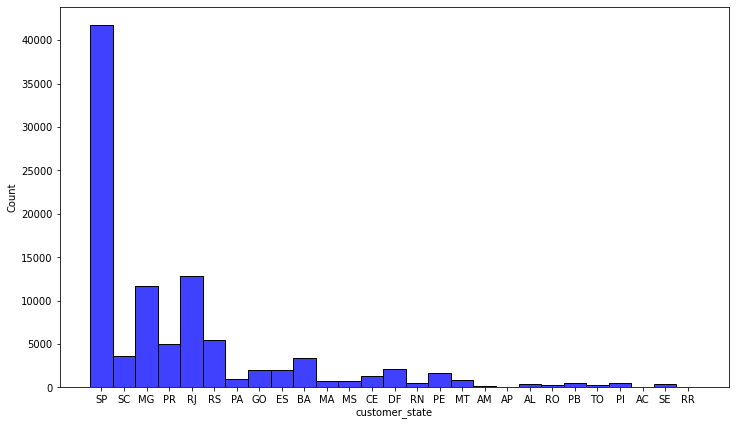

In [ ]:
plt.figure(figsize=(12,7))
sns.histplot(x=customer['customer_state'],data=customer,color='blue')
plt.show()

In [ ]:
top_10_cities=customer['customer_city'].value_counts().nlargest(10)
top_10_cities

sao paulo                15540
rio de janeiro            6882
belo horizonte            2773
brasilia                  2131
curitiba                  1521
campinas                  1444
porto alegre              1379
salvador                  1245
guarulhos                 1189
sao bernardo do campo      938
Name: customer_city, dtype: int64

In [ ]:
city_df=customer.groupby('customer_city').count()['customer_id'].reset_index()

Text(0, 0.5, 'Number of Customers')

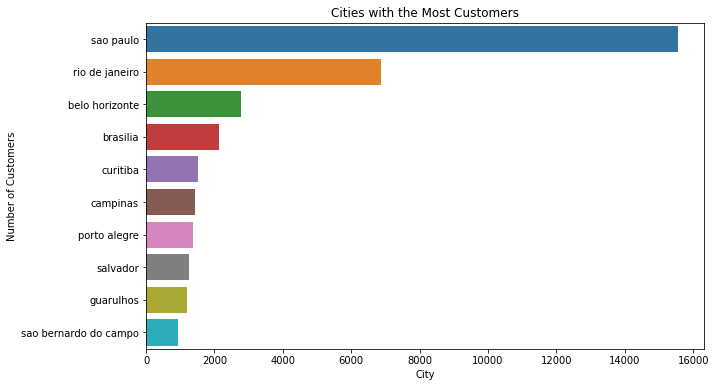

In [ ]:
#Customer Frequency by State

plt.figure(figsize=(10,6))
sns.barplot(data = city_df.sort_values('customer_id', ascending = False).nlargest(10,'customer_id'), x = 'customer_id', 
            y = 'customer_city',)
plt.title('Cities with the Most Customers')
plt.xlabel('City')
plt.ylabel('Number of Customers')

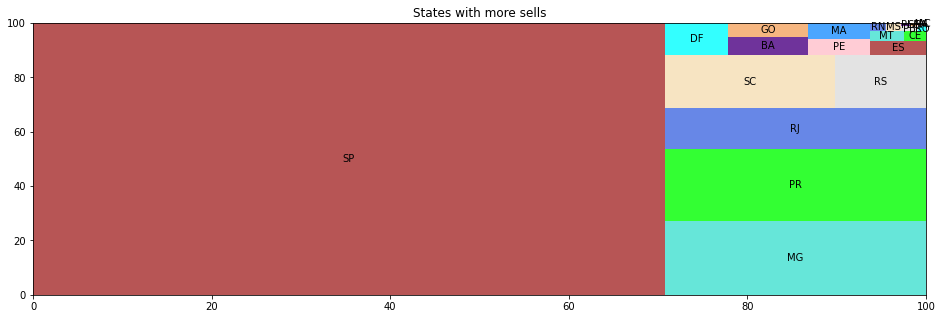

In [ ]:
#Seller's Frequency by State

totalSellerByState = df.groupby('seller_state')['order_id'].nunique().sort_values(ascending=False)
totalSellerByState
fig, ax = plt.subplots(1, figsize = (16,5))
plt.title('States with more sells')

sq.plot(sizes= totalSellerByState,
        color = ['brown','turquoise','lime','royalblue','wheat','gainsboro','aqua','indigo','sandybrown','pink','dodgerblue'],
        label= totalSellerByState.index,
        alpha = .8)

plt.show()

In [ ]:
products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [ ]:
print("Number of unique categories: ", len(products.product_category_name.unique()))

Number of unique categories:  73


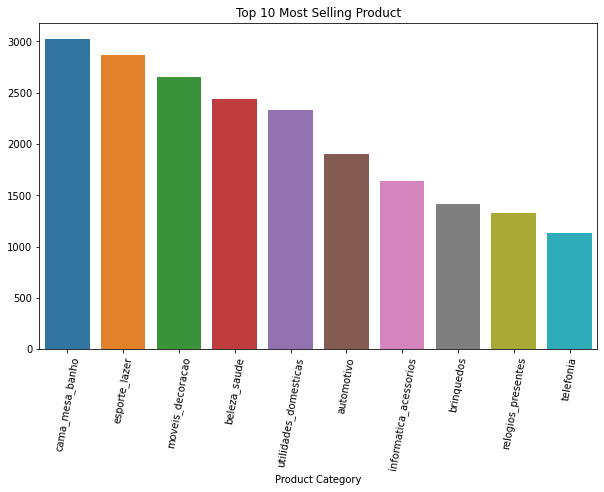

In [ ]:
#Best Selling Product

plt.figure(figsize=(10,6))
top_10_prod_categories = products.groupby('product_category_name')['product_id'].count().sort_values(ascending=False).head(10)
sns.barplot(x=top_10_prod_categories.index, y=top_10_prod_categories.values)
plt.xticks(rotation=80)
plt.xlabel('Product Category')
plt.title('Top 10 Most Selling Product');
plt.show()

In [ ]:

order_item.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [ ]:
order_item.seller_id.value_counts().head(5)

6560211a19b47992c3666cc44a7e94c0    2033
4a3ca9315b744ce9f8e9374361493884    1987
1f50f920176fa81dab994f9023523100    1931
cc419e0650a3c5ba77189a1882b7556a    1775
da8622b14eb17ae2831f4ac5b9dab84a    1551
Name: seller_id, dtype: int64

In [ ]:
sellers.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


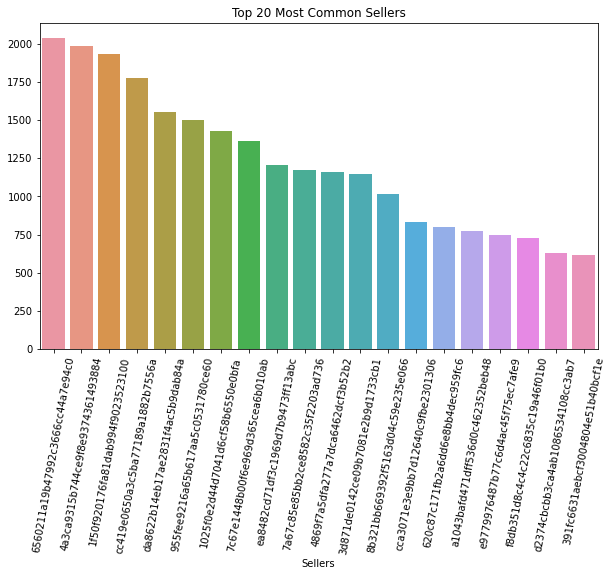

In [ ]:
plt.figure(figsize=(10,6))
top_20_sellers = order_item.groupby('seller_id')['order_item_id'].count().sort_values(ascending=False).head(20)
sns.barplot(x=top_20_sellers.index, y=top_20_sellers.values)
plt.xticks(rotation=80)
plt.xlabel('Sellers')
plt.title('Top 20 Most Common Sellers');
plt.show()

In [ ]:
df['seller_state'][df['seller_id'].isin(top_20_sellers.index)].value_counts().head()

SP    23821
RJ      817
MG      805
Name: seller_state, dtype: int64

In [ ]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [ ]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99441 non-null  object
 5   order_delivered_carrier_date   99441 non-null  object
 6   order_delivered_customer_date  99441 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [ ]:
orders["purchaseDate"] = pd.to_datetime(orders["order_purchase_timestamp"], format='%Y-%m-%d %H:%M:%S').dt.date
orders["purchaseDate"] = orders["purchaseDate"].astype("datetime64[ns]")

In [ ]:
orders.groupby(orders["purchaseDate"].dt.date)

In [ ]:
orders["purchaseYear"] = pd.DatetimeIndex(orders["purchaseDate"]).year

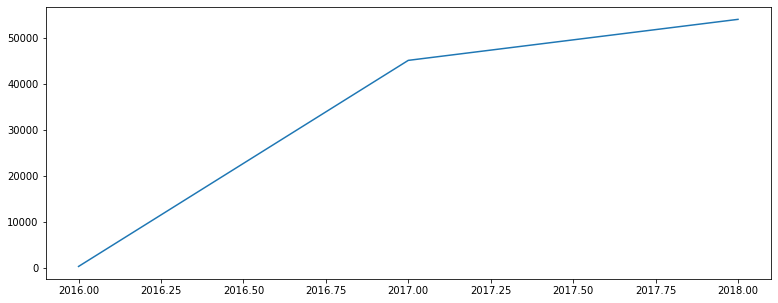

In [ ]:
plt.figure(figsize=(13,5))
orders["purchaseYear"].value_counts().plot()

In [ ]:
order_payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [ ]:
top_payment_type = order_payments['payment_type'].value_counts(ascending=False)
top_payment_type

credit_card    76795
boleto         19784
voucher         5775
debit_card      1529
not_defined        3
Name: payment_type, dtype: int64

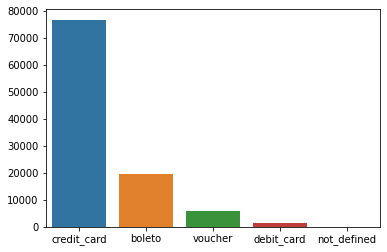

In [ ]:
a = top_payment_type.index
b = top_payment_type.values
sns.barplot(x=a,y=b)

In [ ]:
order_reviews['review_score'].value_counts()

5    57328
4    19142
1    11424
3     8179
2     3151
Name: review_score, dtype: int64

In [ ]:
order_reviews['review_score'].unique()

array([4, 5, 1, 3, 2])

Text(0, 0.5, 'Counts')

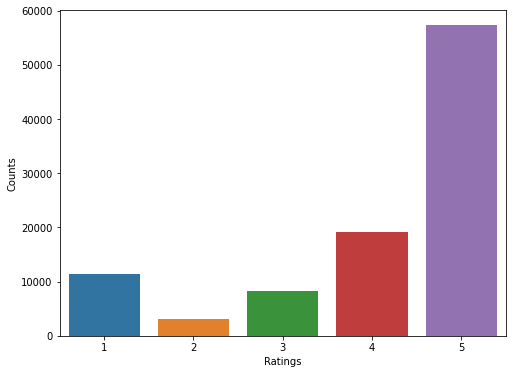

In [ ]:
plt.figure(figsize=(8,6))
sns.barplot(x=order_reviews['review_score'].value_counts().index,y=order_reviews['review_score'].value_counts().values)
plt.xlabel('Ratings')
plt.ylabel('Counts')

In [ ]:
product_reviews_mean = df.groupby('product_category_name').mean()['review_score'].reset_index()

In [ ]:
product_reviews_mean.head(3)

,product_category_name,review_score
0,agro_industria_e_comercio,4.150794
1,alimentos,4.228963
2,alimentos_bebidas,4.324138


In [ ]:
top_10_ratings = product_reviews_mean.sort_values('review_score', ascending = False).nlargest(10,'review_score')

Text(0, 0.5, 'Product Category Name')

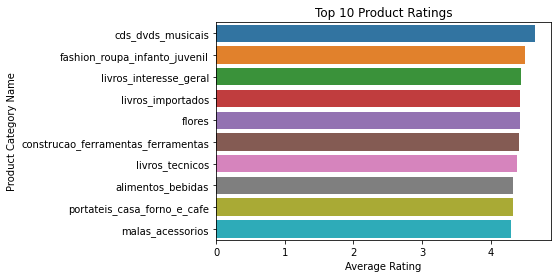

In [ ]:
sns.barplot(data = top_10_ratings, x = 'review_score', y = 'product_category_name')
plt.title('Top 10 Product Ratings')
plt.xlabel('Average Rating')
plt.ylabel('Product Category Name')

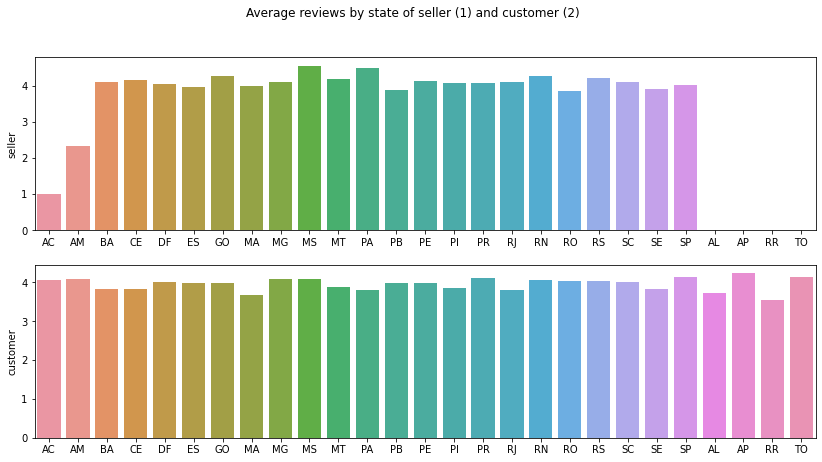

In [ ]:
sellerStateReviews = df.groupby('seller_state')['review_score'].mean()
customerStateReviews = df.groupby('customer_state')['review_score'].mean()
concatReviews = pd.concat([sellerStateReviews.rename('seller'), customerStateReviews.rename('customer')], axis=1)

fig, axes = plt.subplots(2, 1, figsize=(14,7))
fig.suptitle('Average reviews by state of seller (1) and customer (2)')
sns.barplot(x=concatReviews.index, y=concatReviews.seller, ax=axes[0])
sns.barplot(x=concatReviews.index, y=concatReviews.customer, ax=axes[1])

In [ ]:
dateColumns = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']

for column in dateColumns:
    df[column] = pd.to_datetime(df[column], errors='coerce')

#Calculate the difference between the estimated date and the delivery (negative values means delay)
df['DiffDeliveryDays'] = ((df['order_estimated_delivery_date'] - df['order_delivered_customer_date']).dt.days) + 1

#Calculate the time between end of purchase and delivery
df['DeliveryCountDays'] = ((df['order_delivered_customer_date'] - df['order_purchase_timestamp']).dt.days)

In [ ]:
df[['order_estimated_delivery_date', 'order_delivered_customer_date', 'DiffDeliveryDays', 'order_purchase_timestamp','DeliveryCountDays']]

,order_estimated_delivery_date,order_delivered_customer_date,DiffDeliveryDays,order_purchase_timestamp,DeliveryCountDays
0,2017-10-18,2017-10-10 21:25:13,8,2017-10-02 10:56:33,8
1,2017-10-18,2017-10-10 21:25:13,8,2017-10-02 10:56:33,8
2,2017-10-18,2017-10-10 21:25:13,8,2017-10-02 10:56:33,8
3,2017-08-28,2017-08-18 14:44:43,10,2017-08-15 18:29:31,2
4,2017-08-15,2017-08-07 18:30:01,8,2017-08-02 18:24:47,5
...,...,...,...,...,...
115603,2018-07-20,2018-07-20 00:00:00,1,2018-07-11 22:27:32,8
115604,2018-05-28,2018-05-21 17:14:08,7,2018-05-16 14:50:54,5
115605,2018-06-28,2018-06-16 17:48:30,12,2018-06-13 12:19:26,3
115606,2018-09-04,2018-08-22 17:02:23,13,2018-08-07 10:52:58,15


In [ ]:
reviewsByDates = pd.merge(df[['order_id', 'seller_id','DeliveryCountDays', 'DiffDeliveryDays', 'order_purchase_timestamp']],order_reviews,on='order_id', how='left')
                          
reviewsByDates.corr()['review_score'].drop('review_score')

DeliveryCountDays   -0.326297
DiffDeliveryDays     0.253482
Name: review_score, dtype: float64

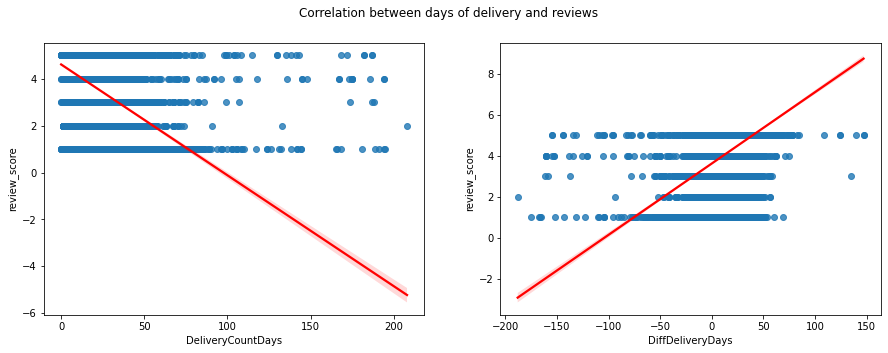

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Correlation between days of delivery and reviews')

sns.regplot(x='DeliveryCountDays', y='review_score', data=reviewsByDates, ax=axes[0], line_kws={"color": "red"})

sns.regplot(x='DiffDeliveryDays', y='review_score', data=reviewsByDates, ax=axes[1], line_kws={"color": "red"})

In [ ]:
print('Average review score for dalayed items:',(reviewsByDates[reviewsByDates.DiffDeliveryDays<0]['review_score'].mean()))
print('Average review score for anticipated items:',(reviewsByDates[reviewsByDates.DiffDeliveryDays>0]['review_score'].mean()))

Average review score for dalayed items: 2.253935660506502
Average review score for anticipated items: 4.153105449437683


In [ ]:
# Customer Sentiment Analysis using the review comments

order_reviews.head()

,review_id,order_id,review_score,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NONE,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NONE,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NONE,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [ ]:
len(order_reviews)

99224

In [ ]:
reviews_df = order_reviews[~(order_reviews['review_comment_message'] == 'NONE')]

In [ ]:
reviews_df = reviews_df[['review_score','review_comment_message']]

In [ ]:
reviews_df.head()

,review_score,review_comment_message
3,5,Recebi bem antes do prazo estipulado.
4,5,Parabéns lojas lannister adorei comprar pela I...
9,4,aparelho eficiente. no site a marca do aparelh...
12,4,"Mas um pouco ,travando...pelo valor ta Boa.\r\n"
15,5,"Vendedor confiável, produto ok e entrega antes..."


In [ ]:
!python -m spacy download pt_core_news_sm

     |████████████████████████████████| 21.2 MB 1.2 MB/s 
  Created wheel for pt-core-news-sm: filename=pt_core_news_sm-2.2.5-py3-none-any.whl size=21186281 sha256=34241c27732ae7af3ad5e2b0c03651d2de8e22118783caa3066f270fa2029d2b
  Stored in directory: /tmp/pip-ephem-wheel-cache-wslkg62j/wheels/c3/f9/0c/5c014a36941a00f5df5fc0756cb961d7c457a978e697a6ce3b
Successfully built pt-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('pt_core_news_sm')


In [ ]:
import re, nltk, spacy, string
import pt_core_news_sm
nlp = pt_core_news_sm.load()
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [ ]:
def clean_text(text):
    text = text.lower()  # Make the text lowercase
    text = re.sub('\[.*\]','', text).strip() # Remove text in square brackets if any
    text = text.translate(str.maketrans('', '', string.punctuation)) # Remove punctuation
    text = re.sub('\S*\d\S*\s*','', text).strip()  # Remove words containing numbers
    return text.strip()

In [ ]:
reviews_df.review_comment_message = reviews_df.review_comment_message.apply(lambda x: clean_text(x))

In [ ]:
# portugese stopwords
stopwords = nlp.Defaults.stop_words

# lemmatizer function
def lemmatizer(text):
    doc = nlp(text)
    sent = [token.lemma_ for token in doc if not token.text in set(stopwords)]
    return ' '.join(sent)

In [ ]:
reviews_df['lemma'] = reviews_df.review_comment_message.apply(lambda x: lemmatizer(x))

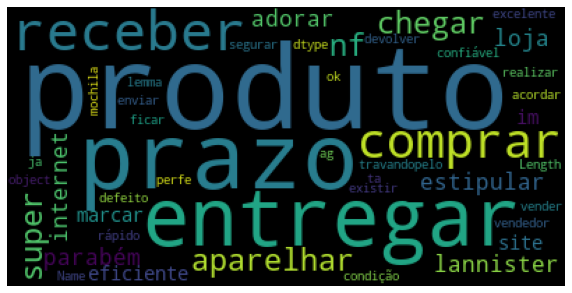

In [ ]:

from wordcloud import WordCloud

wordcloud = WordCloud(stopwords=stopwords,max_words=50).generate(str(reviews_df.lemma))

print(wordcloud)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

**Time series forecas**
</br>
To predict the sum of the sales value for the coming weeks, we are going to use an ARIMA model

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
dataTime = df[['order_id', 'order_purchase_timestamp', 'price']].set_index('order_purchase_timestamp', inplace=False)

dataTimeMean = pd.DataFrame(dataTime.resample('W')['price'].sum()) #resample using weeks as parameter
# dataTimeMean = dataTimeMean.fillna(0)
dataTimeMean.drop(dataTimeMean.tail(2).index, inplace=True) # Drop the last observations with 0 

#Decompose Time Series
decompose = seasonal_decompose(dataTimeMean, extrapolate_trend=12)

#Trend
obs = decompose.observed
#Trend
trend = decompose.trend
#Seazonal
seazon = decompose.seasonal
#Error
random = decompose.resid

In [ ]:
!pip install pmdarima
from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest

adfTest = ADFTest(alpha=0.05)
adfTest.should_diff(dataTimeMean)

(0.08936149577560408, True)

In [ ]:
dataTimeMean['x1'] = dataTimeMean.price.shift(1)

dataTimeMean.dropna(axis=0, inplace=True)

dataTimeMean.head()

,price,x1
order_purchase_timestamp,,
2016-09-11,59.50,72.89
2016-09-18,0.00,59.50
2016-09-25,0.00,0.00
2016-10-02,100.00,0.00
2016-10-09,46411.49,100.00


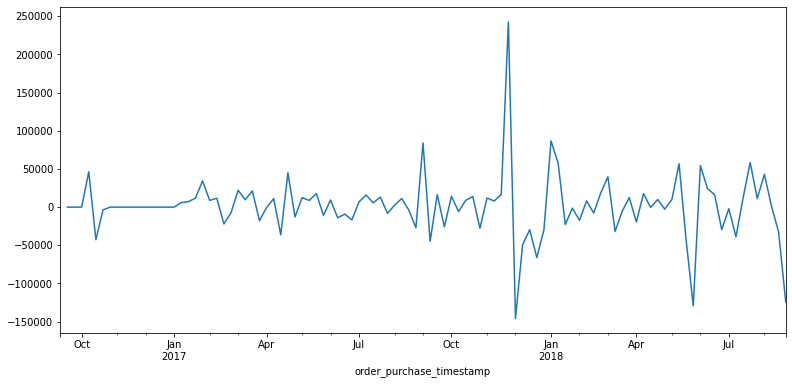

In [ ]:
#Making the series stationary
dataTimeMean.price.diff(1).plot(figsize=(13, 6))

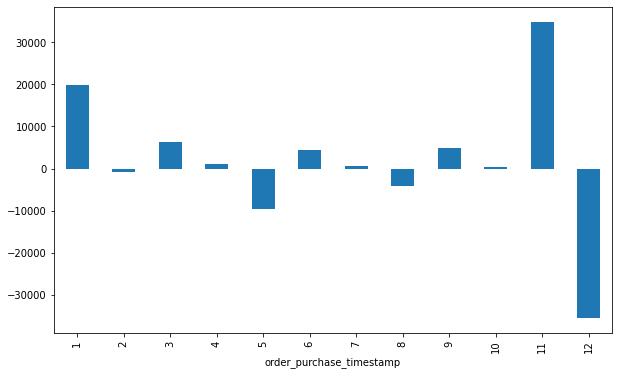

In [ ]:
dataTimeMean.price.diff(1).groupby(dataTimeMean.index.month).mean().plot(kind='bar', figsize=(10, 6))

In [ ]:
from sklearn.ensemble import RandomForestRegressor
randomF = RandomForestRegressor(n_estimators = 500, random_state=0).fit(X, y)

predictions_RandomForest = randomF.predict(X)
print('RMSE for Random Forest was: \n', mean_squared_error(y, predictions_RandomForest, squared=False))

RMSE for Random Forest was: 
 15604.507993476196


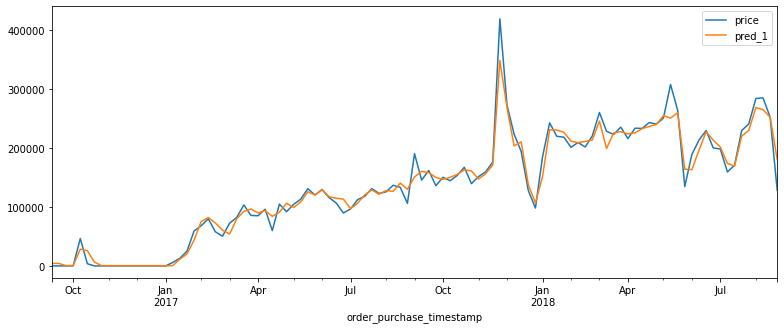

In [ ]:
dataTimeMean['pred_1'] = randomF.predict(X)
dataTimeMean[['price', 'pred_1']].plot(figsize=(13, 5))

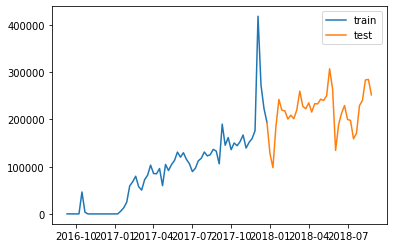

In [ ]:
train_size = int(len(dataTimeMean.price) * 2 / 3)

train = X[:train_size]
test = X[train_size-1:]

plt.plot(train)
plt.plot(test)
plt.legend(['train', 'test'])

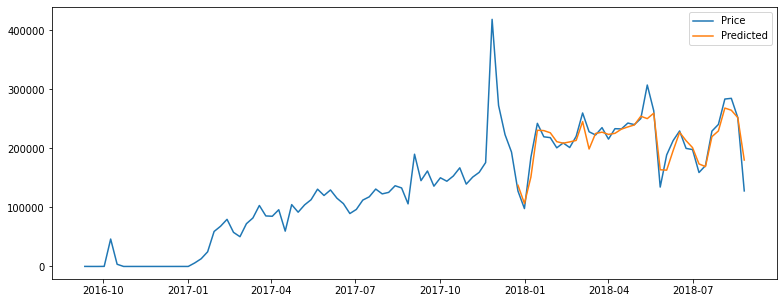

In [ ]:
plt.figure(figsize=(13, 5))
plt.plot(dataTimeMean.price)
forecast = randomF.predict(test)
plt.plot(test.index, forecast)
plt.legend(['Price', 'Predicted'])

In [ ]:
lastPrice = dataTimeMean['price'][-1]

datesToPredict = pd.Series(dataTimeMean.index[-1] + pd.Timedelta('1 w'))

forecastData =  pd.DataFrame({'x1': str(lastPrice)}, index=datesToPredict)  
forecastData.x1 = pd.to_numeric(forecastData.x1)


print("Next week's predicted price is: R$", randomF.predict(forecastData))

Next week's predicted price is: R$ [106661.65652]


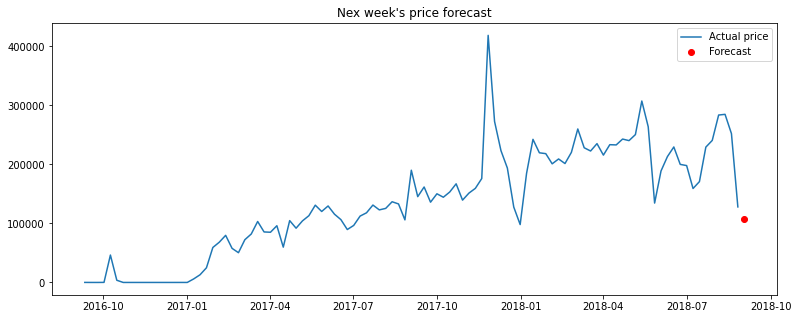

In [ ]:
plt.figure(figsize=(13, 5))
plt.plot(dataTimeMean.price)
forecast = xgb.predict(test)
plt.scatter(forecastData.index, randomF.predict(forecastData), color='red')
plt.title("Nex week's price forecast")
plt.legend(['Actual price', 'Forecast'])